In [1]:
%%time

import os
from irradiance_functions import *
from electrics_functions import *
import matplotlib.pyplot as plt
import pickle

def predef(sizeA):
    EY = {
        'JscDirect': np.zeros((8760, sizeA[0])),
        'JscDiffuse': np.zeros((8760, sizeA[0])),
        'JscAlbedo': np.zeros((8760, sizeA[0])),
        'Jsc': np.zeros((8760, sizeA[0])),
        'Voc_SJ': np.zeros((8760, sizeA[0])),
        'FF_SJ': np.zeros((8760, sizeA[0])),
        'JMPP_SJ': np.zeros((8760, sizeA[0])),
        'VMPP_SJ': np.zeros((8760, sizeA[0])),
        'Power_SJ': np.zeros((8760, sizeA[0])),
        'Voc': np.zeros((8760, sizeA[0])),
        'FF': np.zeros((8760, sizeA[0])),
        'JMPP': np.zeros((8760, sizeA[0])),
        'VMPP': np.zeros((8760, sizeA[0])),
        'Power': np.zeros((8760, sizeA[0])),
        'PCE': np.zeros((8760, sizeA[0])),
        'Voc_Tandem': np.zeros(8760),
        'FF_Tandem': np.zeros(8760),
        'JMPP_Tandem': np.zeros(8760),
        'VMPP_Tandem': np.zeros(8760),
        'Power_Tandem': np.zeros(8760),
        'PCE_Tandem': np.zeros(8760),
    }
    return EY

# Set the initial random seed
np.random.seed(0)

# Define the wavelength range
lambda_ = np.arange(300, 1205, 5)

# Generate random subkeys by reseeding or using unique seeds
np.random.seed(1)  # First subkey
A1 = np.random.rand(90, len(lambda_))

np.random.seed(2)  # Second subkey
A2 = np.random.rand(90, len(lambda_))

# Stack the arrays into a single list
A = np.array([A1, A2])

CodeLocation = '722020TYA'  # Code to be looked up from \Irradiance\Dataset_TMY3\User Manual TMY3.pdf
AliasLocation = 'Miami'  # To be specified

irradiance = read_irradiance(CodeLocation, AliasLocation)

lambda_values = irradiance['Irr_spectra_clouds_wavelength'].flatten()

thetasun = irradiance['Data_TMY3']['Data_TMY3'][:, 6]
phisun = irradiance['Data_TMY3']['Data_TMY3'][:, 7]


SolarCellRotationAngle = 180
SolarCellTiltAngle = 20
phisun0 = phisun
thetasun0 = thetasun

# Constants and initialization
GI = get_illumination(SolarCellRotationAngle, SolarCellTiltAngle, 0)
GI_inv = 1 - GI
phisun_rot, thetasun_rot = rotatesunangle(SolarCellRotationAngle, SolarCellTiltAngle, 0, phisun0, thetasun0)
theta = np.deg2rad(np.linspace(0, 89, 90))
dtheta = np.deg2rad(1)
dphi = np.deg2rad(1)
dlambda = lambda_[1] - lambda_[0]
EY = predef((len(A),))
alpha = np.zeros(8760)
beta = alpha
gamma = alpha
S = np.zeros(8760)

# Define the electrics dictionary with parameters
electrics = {
    'configuration': '2T',
    'shunt': 'with',
    'RshTandem': 1300,
    'RsTandem': 3,
    'Rsh': [1300, 1000],
    'Rs': [2, 1],
    'CE': [1, 1],
    'j0': [2.7e-18, 1e-12],
    'n': [1.1, 1],
    'Temp': [25, 25],
    'NOCT': np.array([48, 48]),
    'tcJsc': [0.0002, 0.00032],
    'tcVoc': [-0.002, -0.0041]
}

IrradianceDifH = irradiance["Irr_spectra_clouds_diffuse_horizontal"]
IrradianceDifN = IrradianceDifH / np.pi
IrradianceDirH = irradiance["Irr_spectra_clouds_direct_horizontal"]
IrradianceDirN = (np.ceil(thetasun0) < 90)[:, np.newaxis] * IrradianceDirH / np.abs(np.cos(np.deg2rad(thetasun0)))[:, np.newaxis]

IdifH = trim_irradiance(lambda_, IrradianceDifH, lambda_values)
IdifN = trim_irradiance(lambda_, IrradianceDifN, lambda_values)
IdirH = trim_irradiance(lambda_, IrradianceDirH, lambda_values)
IdirN = trim_irradiance(lambda_, IrradianceDirN, lambda_values)

TempAmbient = irradiance['Data_TMY3']['Data_TMY3'][:, 13]



# Save to a file
with open('irradiance_data.pkl', 'wb') as file:
    pickle.dump(irradiance, file)
    
    
# Loop over all hours of the considered year
for j in range(8760):

    # Direct normal irradiance contribution
    direct_contrib = IdirN[j, :] * np.cos(np.deg2rad(thetasun[j]))

    # Diffuse irradiance contribution
    hemisphere_integral = np.sum(np.ones((90, 361)), axis=1) * np.sin(theta) * np.cos(theta)
    diffuse_contrib = IdifN[j, :] * np.sum(hemisphere_integral) * dphi * dtheta

    # Total incident solar radiation for hour j
    S[j] = np.sum(direct_contrib + diffuse_contrib) * dlambda

    idx_phisun = int(np.mod(np.round(phisun[j], 0) + 1, 360))
    idx_thetasun = int(np.round(thetasun[j], 0) + 1)

    for k in range(len(A)):

        if idx_thetasun <= 90 and GI[idx_thetasun, idx_phisun] == 1:
            direct = (A[k][0].reshape(-1, 1)[idx_thetasun, :] * IdirN[j, :] * (
                        electrics['CE'][k] * lambda_)).sum() * np.cos(np.deg2rad(thetasun[j]))
        elif len(A[0]) > 1 and 181 - idx_thetasun < 90 and thetasun0[j] <= 90:
            direct = (A[k][1].reshape(-1, 1)[181 - idx_thetasun, :] * IdirN[j, :] * (
                        electrics['CE'][k] * lambda_)).sum() * np.cos(np.deg2rad(181 - thetasun[j]))
        else:
            direct = 0

        EY['JscDirect'][j, k] = dlambda * direct

        tmp_diffuse = np.dot((IdifN[j, :] * lambda_).reshape(-1, 1),
                             (np.sum(GI[:90, :], axis=1) * np.sin(theta) * np.cos(theta)).reshape(-1, 1).T)
        diffuse = (electrics['CE'][k] * (A[k][0].T.reshape(-1, 1) * tmp_diffuse)).sum()
        EY['JscDiffuse'][j, k] = dphi * dtheta * dlambda * diffuse

        if len(A[0]) > 1:
            tmp_diffuse_back = np.dot((IdifN[j, :] * lambda_).reshape(-1, 1),
                                      (np.sum(GI_inv[:90, :], axis=1) * np.sin(theta) * np.cos(theta)).reshape(-1, 1).T)
            diffuse += (electrics['CE'][k] * (A[k][1].T.reshape(-1, 1) * tmp_diffuse_back)).sum()
            EY['JscDiffuse'][j, k] = dphi * dtheta * dlambda * diffuse

        EY['Jsc'][j, :] = EY['JscDirect'][j, :] + EY['JscDiffuse'][j, :]

        
# Calculation of the module temperature based on the NOCT
if isinstance(electrics['NOCT'], np.ndarray):
    electrics['Temp'] = np.zeros((8760, A.shape[1]))
    if len(electrics['NOCT']) != A.shape[1]:
        electrics['NOCT'] = electrics['NOCT'][0] * np.ones(A.shape[1])
    for k in range(A.shape[1]):
        electrics['Temp'][:, k] = TempAmbient + (electrics['NOCT'][k] - 20) / 800 * S

EY['TempAmbient'] = TempAmbient
EY['TempModule'] = electrics['Temp']

CPU times: user 9.11 s, sys: 1.64 s, total: 10.7 s
Wall time: 9.51 s


In [2]:
%%time
for j in range(8760):
    for k in range(len(A)):

        # Calculate single cells in tandem device in 2T
        EY['Voc'][j, k], EY['FF'][j, k], EY['Power'][j, k], EY['JMPP'][j, k], EY['VMPP'][j, k] = \
            calcSingleElectrics(min(EY['Jsc'][j] * 10 ** (-4)),
                                electrics['Rs'][k], electrics['Rsh'][k],
                                electrics['j0'][k],
                                electrics['n'][k], electrics['Temp'][k])

        EY['Voc_SJ'][j, k], EY['FF_SJ'][j, k], EY['Power_SJ'][j, k], EY['JMPP_SJ'][j, k], EY['VMPP_SJ'][j, k] = \
            calcSingleElectrics(EY['Jsc'][j, k] * 10 ** (-4),
                                electrics['Rs'][k], electrics['Rsh'][k],
                                electrics['j0'][k],
                                electrics['n'][k], electrics['Temp'][k])


ValueError: operands could not be broadcast together with shapes (100,) (90,) 

In [3]:
%%time

TandemVOCs = []
TandemFFs = []
TandemP_els = []
TandemJMPPs = []
TandemVMPPs = []

for jsc in EY['Jsc'] * 10 ** (-4):
    TandemVOC, TandemFF, TandemP_el, TandemJMPP, TandemVMPP = calctandem_with_single(electrics, min(jsc))
    TandemVOCs.append(TandemVOC)
    TandemFFs.append(TandemFF)
    TandemP_els.append(TandemP_el)
    TandemJMPPs.append(TandemJMPP)
    TandemVMPPs.append(TandemVMPP)

EY["Voc_Tandem"] = TandemVOCs
EY["FF_Tandem"] = TandemFFs
EY["Power_Tandem"] = TandemP_els
EY["JMPP_Tandem"] = TandemJMPPs
EY["VMPP_Tandem"] = TandemVMPPs

# Assuming these variables are defined as NumPy arrays beforehand
# IrradianceDifH, IrradianceDirN, EY.Power_Tandem, EY.Power, IrradianceDifN, IrradianceDirH, A

# Calculate global irradiance
Iglob = np.sum(IrradianceDifH + IrradianceDirN, axis=1)

# Reshape Iglob to be (8760, 1) for broadcasting with EY['Power']
Iglob_reshaped = Iglob[:, np.newaxis]  # or use Iglob.reshape(-1, 1)

# Calculate Tandem PCE
EY['TandemPCE'] = EY['Power_Tandem'] / Iglob

EY['TandemPCE'][np.isnan(EY['TandemPCE'])] = 0
EY['TandemPCE'][np.isinf(EY['TandemPCE'])] = 0
EY['TandemPCE'][EY['TandemPCE']<0] = 0

# Calculate overall PCE
EY['PCE'] = EY['Power'] / Iglob_reshaped
EY['PCE'][np.isnan(EY['PCE'])] = 0
EY['PCE'][EY['PCE']<0] = 0

# Add irradiance to EY structure
EY['IrradianceDifH'] = np.sum(IrradianceDifH, axis=1)
EY['IrradianceDifN'] = np.sum(IrradianceDifN, axis=1)
EY['IrradianceDirH'] = np.sum(IrradianceDirH, axis=1)
EY['IrradianceDirN'] = np.sum(IrradianceDirN, axis=1)

# Add absorption Atop and Abot to EY
EY['A'] = A

# Post-process hourly resolved data
EY['TandemPowerTotal'] = np.sum(EY['Power_Tandem']) / 1000
EY['TandemPCEmean'] = np.mean(EY['TandemPCE'])

print(f'The annual energy yield is {EY["TandemPowerTotal"]} kWh/a/m²')
print(f'The average power conversion efficiency is {EY["TandemPCEmean"]*100} %')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

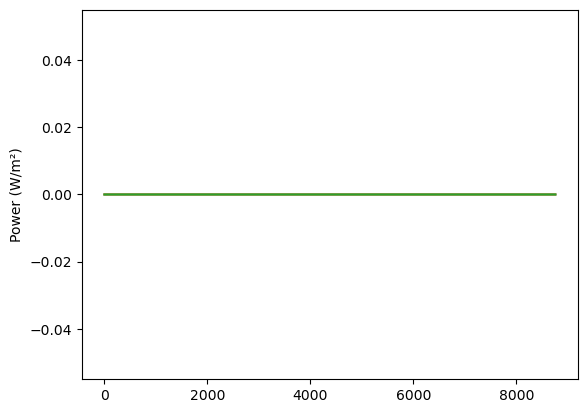

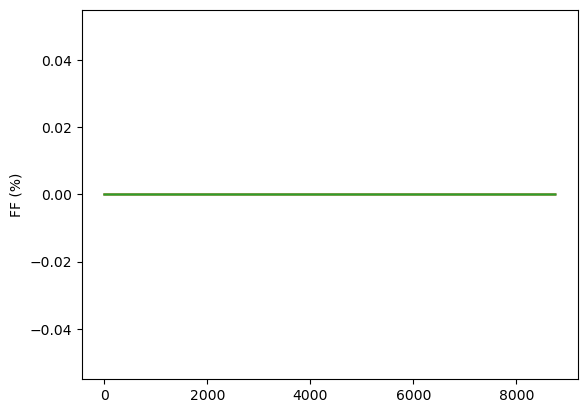

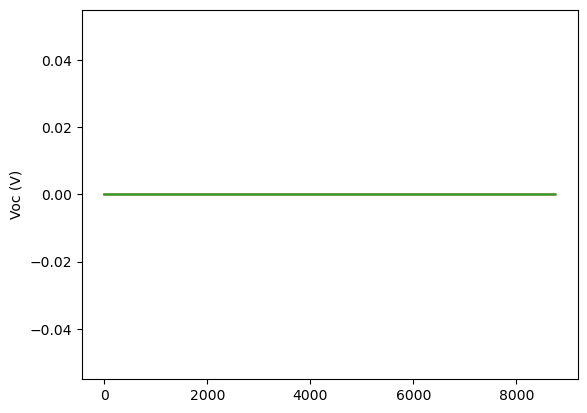

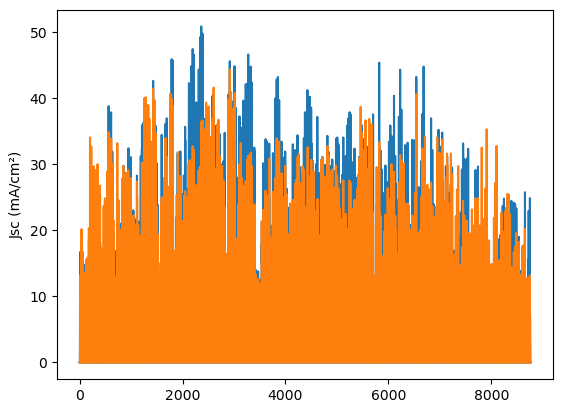

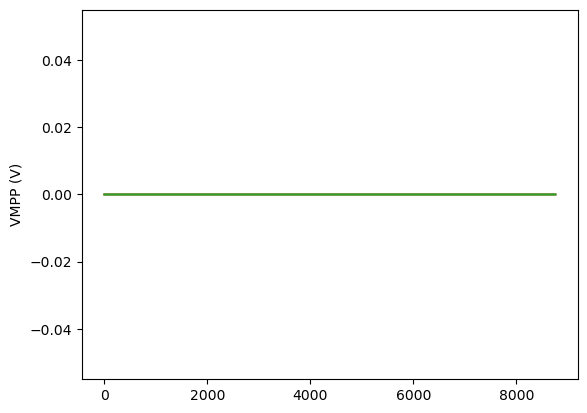

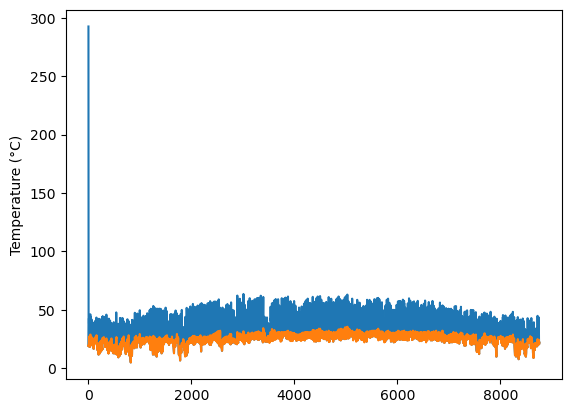

In [4]:
plt.figure()
plt.plot(EY['Power_Tandem'])
plt.plot(EY['Power'])
plt.ylabel('Power (W/m²)')
plt.show()

plt.figure()
plt.plot(EY['FF_Tandem'])
plt.plot(EY['FF'])
plt.ylabel('FF (%)')
plt.show()

plt.figure()
plt.plot(EY['Voc_Tandem'])
plt.plot(EY['Voc'])
plt.ylabel('Voc (V)')
plt.show()

plt.figure()
plt.plot(EY['Jsc']*10**(-4))
plt.ylabel('Jsc (mA/cm²)')
plt.show()

plt.figure()
plt.plot(EY['VMPP_Tandem'])
plt.plot(EY['VMPP'])
plt.ylabel('VMPP (V)')
plt.show()

plt.figure()
plt.plot(EY['TempModule'][:,1])
plt.plot(EY['TempAmbient'])
plt.ylabel('Temperature (°C)')
plt.show()